# Link Functions, Logistic Regressions, and Advanced AB Testing
**Current Status**: Code grade notebook

**Insert picture of a video game store**

Congratulations, in this lesson we are all data scientists at a video game shop. Our job is to help sell more video games. You have all sorts of data on customers and your boss wants to know who to market to. But before we get ahead of ourselves lets talk through the over vi

## Bayesian AB Test Review
* Revisit the basic AB test
* Estimate probability of a potential customer converting
* Interpret the result

## AB Testing Limitations
* Try AB Testing with a continuous observed value
  * Age of customer
* Understand why the "obvious" approaches fail

## Generalizing linear models with link functions
* Introduce the most important concept of this course  
  * Link functions
  * Generalized linear models
* (Re)introduce Transformations


## End to End "A Infinite Testing"
* Apply our new GLM 

## Logistic Regression in the real world
* Work through an example with a real world dataset

In [82]:
import bambi as bmb
import arviz as az
from scipy import stats
from scipy import special
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import seaborn as sns

plt.style.use('../notebooks/intuitivebayes.mplstyle')

FIGSIZE = (16, 8)
SEED = 0

In [ ]:
# Will add to dependecies if we agree 
!pip install statsmodels

# Hidden Section: Generate data
**Hello students**

Welcome to the hidden section where we generate the data. We've included this in the notebook purposefully so you can use it to aid your learnings. Simulation is an important tool because

* During learning you can create new scenarios to have an infinite amount of practice data
* During EDA you can use simulation to see what functional
* Check if your models are correctly specified, especially complex models, by simulating data and seeing if you can recover the parameters



In [25]:
np.random.seed(SEED)

samples = 1000

# 1 indicates likes videogames
likes_videogames_bool = stats.bernoulli(p=.5).rvs(samples)
like_videogames_categorical = ["No" if x == 0 else "Yes" for x in likes_videogames_bool]

# Age
age = stats.randint(low=18, high=60).rvs(samples).astype(float)

df = pd.DataFrame({"age":age,
                   "likes_videogames":like_videogames_categorical,
                   "likes_videogames_bool":likes_videogames_bool}).sort_values("age")
df.head()

,age,likes_videogames,likes_videogames_bool
355,18.0,Yes,1
720,18.0,Yes,1
678,18.0,No,0
113,18.0,No,0
425,18.0,No,0


## Simulate our data
Unfortunately there are differing names for the sigmoid function in particular
* logistic (or logistic sigmoid)
* expit

Scipy uses the name expit. Since we use scipy in this course we'll use their naming so you learn both, and also can find the documentation for the code

In [4]:
special.expit(3)

0.9525741268224334

In [26]:
np.random.seed(SEED)

# Parameters of model
intercept = 1
coeff_age = -0.1
coeff_likes_videogames = 2

# Construction of mean p_convert
y = intercept + coeff_age * df["age"] + coeff_likes_videogames * df["likes_videogames_bool"]

# Convert the continuous value to 0 1 bounded
# This is the link function
p_convert = special.expit(y)

# Simulate actual conversions. Rememver a prob of .99 doesn't guarantee someone will convert!
# To see that look at the graph below
converted_bool = stats.bernoulli(p=p_convert).rvs()

df["p_convert"] = p_convert
df["converted_bool"] = converted_bool
df["converted"] = [{1:"Yes", 0:"No"}[outcome] for outcome in converted_bool]
df.head()

,age,likes_videogames,likes_videogames_bool,p_convert,converted_bool,converted
355,18.0,Yes,1,0.768525,1,Yes
720,18.0,Yes,1,0.768525,1,Yes
678,18.0,No,0,0.310026,0,No
113,18.0,No,0,0.310026,0,No
425,18.0,No,0,0.310026,0,No


## Logistic curves

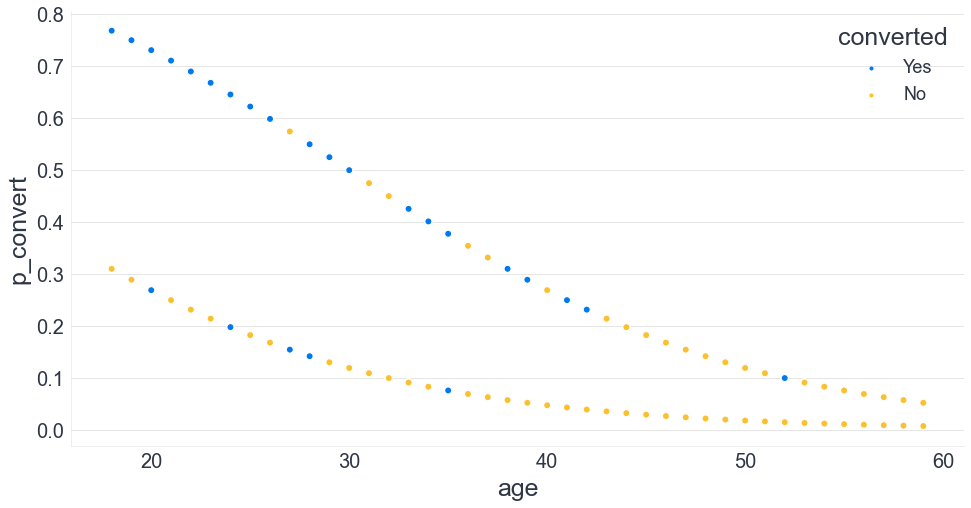

In [85]:
fig, ax = plt.subplots(figsize=FIGSIZE)
sns.scatterplot(x="age", y="p_convert", hue="converted", data=df, ax=ax, s=200);

In [71]:
customers_table = (df.drop("p_convert", axis=1).sample(frac=1, random_state=5).reset_index()
                          [["age", "likes_videogames", "converted", "likes_videogames_bool", "converted_bool"]])
customers_table.head(10)

,age,likes_videogames,converted,likes_videogames_bool,converted_bool
0,40.0,No,Yes,0,1
1,39.0,No,No,0,0
2,26.0,No,Yes,0,1
3,18.0,No,No,0,0
4,29.0,Yes,No,1,0
5,45.0,No,No,0,0
6,44.0,No,No,0,0
7,49.0,Yes,No,1,0
8,26.0,Yes,Yes,1,1
9,47.0,Yes,Yes,1,1


## AB Testing at the video game store
**Insert picture of video game store

# Bayesian AB Test Review
What every company wants to know

## Your bosses as

"Take a look at our website checkout data.I want to know which customers are most likely to convert so we can focus our marketing efforts on them"

"I feel like age is important"

"Oh and also I want the results by the end of the day. I have a meeting with the CEO"

Your boss comes to you with a question, a question that basically every data scientist will get asked in their career. Given a new feature, or some properties about the customer, which are most likely to convert?

Now you're stressed out. You need to turn our results fast. Better get to it

## The data
* The age of the customer
* Whether they like video games or not
* Whether this customer has converted (or not)

In [72]:
customers_table.head(10)

,age,likes_videogames,converted,likes_videogames_bool,converted_bool
0,40.0,No,Yes,0,1
1,39.0,No,No,0,0
2,26.0,No,Yes,0,1
3,18.0,No,No,0,0
4,29.0,Yes,No,1,0
5,45.0,No,No,0,0
6,44.0,No,No,0,0
7,49.0,Yes,No,1,0
8,26.0,Yes,Yes,1,1
9,47.0,Yes,Yes,1,1


So we look at the data we have three things. The age, whether they like video, and whether they converted or not.

We can see four cases here
The first two are obvious.
We have
* People that don't like videogames that didn't convert
* People that did like videogmes and did convert

The second two though are more interesting
* Folks that didn't like videogames but did convert
* Folks that do like videogames that didn't convert


## Summarizing our DF

In [69]:
customers_table_summarized = df[["likes_videogames", "converted_bool"]].groupby("likes_videogames").agg([np.sum, len])
customers_table_summarized.columns = ["converted", "visited"]

In [87]:
customers_table_summarized

,converted,visited
likes_videogames,,
No,51,517
Yes,173,483


Because were short on time we start with the obvious thing, which is the boolean. Lets summarize our customer level data to 2x2 grid for simplicity. Just glancing at the rows we can already see a difference.

## Quick EDA

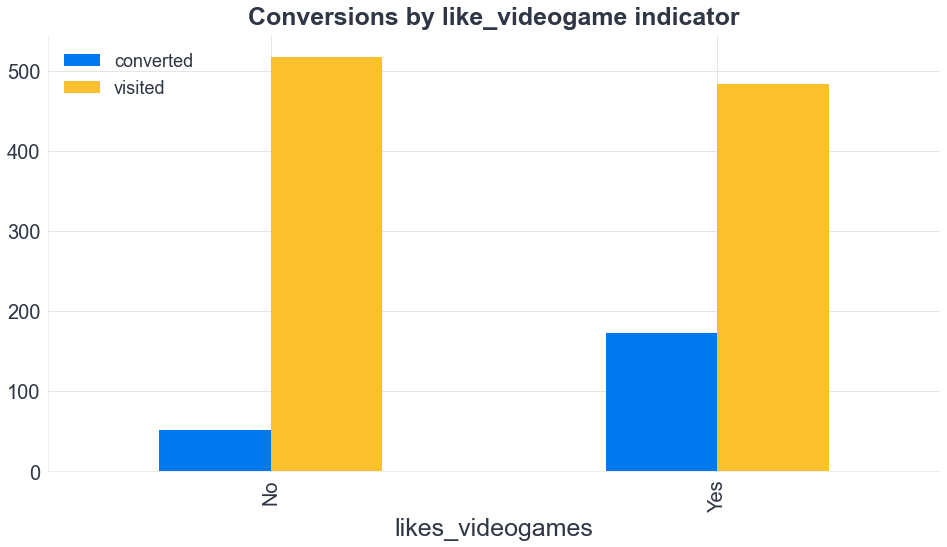

In [77]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.set_title("Conversions by like_videogame indicator")
ax.set_label("Count Conversion")
customers_table_summarized.plot(kind="bar", ax=ax);

We can plot the results as well  just as as double check

## AB Comparison in PyMC

In [79]:
coords = {"likes_videogames": customers_table_summarized.index}

with pm.Model(coords=coords) as ab_test:
    p_convert = pm.Beta("p_convert", 2, 2, dims="likes_videogames")
    
    obs = pm.Binomial("obs", p=p_convert, n=customers_table_summarized["visited"].to_numpy(), 
                      observed=customers_table_summarized["converted"].to_numpy())
    
    idata_likes_video_games= pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_convert]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


We're not quite sure how to AB test in Bambi so for now we just use PyMC. Luckily the model is quite small so its quick to code up. Because we summed Everything here should look familiar to you


## Let's check out results

array([[<AxesSubplot:title={'center':'p_convert'}>,
        <AxesSubplot:title={'center':'p_convert'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

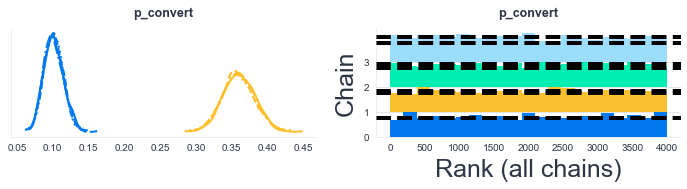

In [84]:
az.plot_trace(idata_likes_video_games, kind="rank_bars");

Our sampling looks good, and we can already see from the KDE estimate that theres a big difference

## Comparing the two groups

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

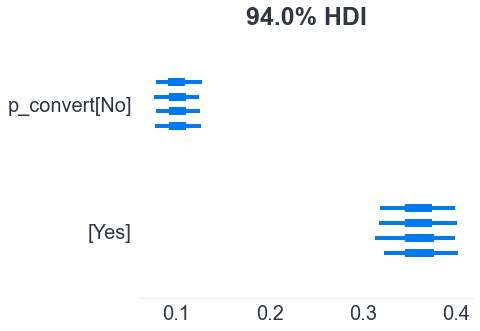

In [86]:
az.plot_forest(idata_likes_video_games);

Great, were now very sure that there's a difference, but this is very obvious. The subtle issue is age but lets discuss that in the next section

## Section Recap
* We want to know how conversion probability relates to
  * Whether people like video games
  * Age
* Coded a PPL model there is a difference in p_conversion on just the preference boolean

# Section 30: Regressing by age
* Your boss then says, well what about age?
  * I'm pretty sure older people are less likely to convert based on my experience
* we can see a trend and fit a line to it but that has problem
* Prob has to be between 0 or 1, most of these are invalid
* But what if we use this function here to squash the input
  * This is nothing new! You saw transformations in the last lesson

* The solution is a link function
  * This is most important part of this course
  * Now we're just formalizing it
* The link function we'll use here is sigmoid
  * Widely used in many fields like Neural nets etc

## How do include a continuous attribute into our framework?
* Our AB Testing framework was based on a discrete attribute (likes_videogame bool)
* How do we extend it?

## A, B, C, D, E, .... Comparison


In [92]:
customers_table["age_buckets"] = pd.cut(customers_table["age"], bins=5)
customers_table

,age,likes_videogames,converted,likes_videogames_bool,converted_bool,age_buckets
0,40.0,No,Yes,0,1,"(34.4, 42.6]"
1,39.0,No,No,0,0,"(34.4, 42.6]"
2,26.0,No,Yes,0,1,"(17.959, 26.2]"
3,18.0,No,No,0,0,"(17.959, 26.2]"
4,29.0,Yes,No,1,0,"(26.2, 34.4]"
...,...,...,...,...,...,...
995,34.0,Yes,No,1,0,"(26.2, 34.4]"
996,23.0,No,Yes,0,1,"(17.959, 26.2]"
997,46.0,No,No,0,0,"(42.6, 50.8]"
998,26.0,No,No,0,0,"(17.959, 26.2]"


In [96]:
customers_table_summarized = customers_table[["age_buckets", "converted_bool"]].groupby("age_buckets").agg([np.sum, len])
customers_table_summarized.columns = ["converted", "visited"]
customers_table_summarized

,converted,visited
age_buckets,,
"(17.959, 26.2]",90,207
"(26.2, 34.4]",68,205
"(34.4, 42.6]",37,180
"(42.6, 50.8]",23,210
"(50.8, 59.0]",6,198


## Another quick EDA

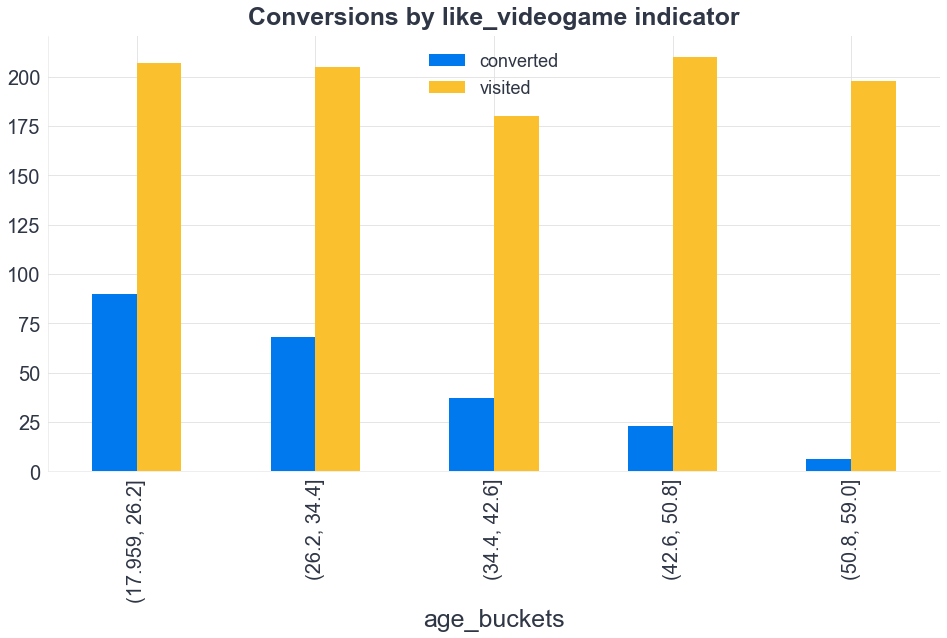

In [97]:
fig, ax = plt.subplots(figsize=FIGSIZE)
ax.set_title("Conversions by like_videogame indicator")
ax.set_label("Count Conversion")
customers_table_summarized.plot(kind="bar", ax=ax);

## Our model

In [102]:
coords = {"age_buckets": customers_table_summarized.index}

with pm.Model(coords=coords) as ab_test:
    p_convert = pm.Beta("p_convert", 2, 2, dims=("age_buckets"))
    
    obs = pm.Binomial("obs", p=p_convert,
                      n=customers_table_summarized["visited"].to_numpy(),
                      observed=customers_table_summarized["converted"].to_numpy())
    
    idata_buckets = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_convert]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


* Our AB testing framework only allowed for discrete variables
* Maybe we could bucket more

## Checking our inference

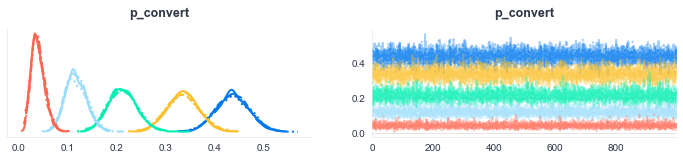

In [105]:
az.plot_trace(idata_buckets);

Now we can see something going on, but this doesn't exactly answer our question of how age relates to conversion directly. We can compare group to group but our boss specifically wants to know exactly how the percentage conversion drops by age.

## But wait we know regression!

In [21]:
with pm.Model() as ab_test:
    sigma = pm.Normal("p_convert", .001)
    β = pm.Normal("β", 0, .001, size=2)
    
    mu = pm.Deterministic("p", β[0] + β[1]*df["age"].to_numpy())
    
    # Switch to Bernoulli because we're predicting individual observations
    obs = pm.Bernoulli("obs", p=mu, observed=df["converted_bool"].to_numpy())


If we take this to the logical extreme we could  plot conversion by age, but since conversion is just 0 or 1 we get this plot. How do we get a covariate for slope?

## Lets try sampling

In [22]:
with ab_test:
    idata_age_reg = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'p_convert': array(-0.4198583), 'β': array([-0.37321148, -0.45775558])}

Initial evaluation results:
{'p_convert': -1.01, 'β': -174401.51, 'obs': -inf}

Ugh we're running into sampler issues. Looking at the error we see some things about negative p_convert but we don't ahve time for this

## Forget Bayes. Go back to OLS

In [193]:
import statsmodels.formula.api as smf
results = smf.ols('converted_bool ~ age', data=df).fit()
results.params

Intercept    0.701618
age         -0.012451
dtype: float64

We obviously see a trend related to age though and we want to use regression. Our bayesian regression isn't working so lets just go to statsmodel and use ordinary least squares. A

And look we immediately get an answer. The probability of conversin drop 1% for every year 
Check it out, now we know the prob of conversion across our observed vals. 

Lets go tell our boss!

## Issues when we look at our result

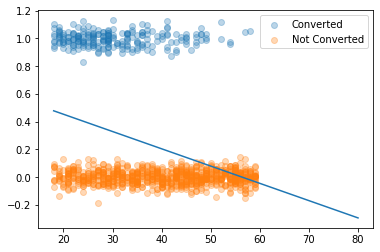

In [195]:
fig, ax = plt.subplots(1)

converted_filter = df["converted_bool"].astype(bool)
# Add some jitter

jittered_y = df["converted_bool"] + stats.norm(scale=.05).rvs(df.shape[0])

alpha = .3
ax.scatter(df.loc[converted_filter, "age"],
          jittered_y[converted_filter],
          label="Converted",
          alpha=alpha)

ax.scatter( df.loc[~converted_filter, "age"],
           jittered_y[~converted_filter],
           label="Not Converted",
           alpha=alpha)


age_x = np.linspace(df["age"].min(), 80, 1000 )
y_pred = results.params[0] + results.params[1]*age_x
plt.plot(age_x, y_pred)
plt.legend()

But before we do lets just double check out plot. 
Negative probability? This is why our sampler was failing, it was telling us something
Oh man if we had reported these results we would have been fired
But look at the age of 60, something seems off?


## Section Recap
* Discrete AB testing is quite straightforward
* Run into issues when we're trying to estimate prob against a continuous variable
  * Discretizing isn't super usfeul
* Regression against average has
  * Non continuous
  * Probability can go over 0 and 1 which is impossible
* A big advantage of modern Bayesian frameworks is they "tell you" when something is wrong
  *  The standard solvers in most other tools don't tell you when something is wrong!
  * They just give you an answer

# Section 40: Link Functions


## Statistics and math review
* Probability is 0 1 bounded
* Linear regression is not

Linear regression will 
What if we can remap our observed to be between 0 and 1?


Turns out we you already know how. Remember our log transformation in the last lesson? What if we can apply a transformation?

## Sigmoid transformation
$$ \large
S(x) = \frac{1}{1 + e^{-x}} = \frac{e^x}{e^x + 1}
$$

Note this is also called
* Logistic 
* Expit 
* Logistic Sigmoid

Here's what it looks like in math

## Plotting the Sigmoid function
**Note** We will switch this to an animation to make it more clear what's happening

In [ ]:
x = np.linspace(-10, 10, 1000)
y = x
transformed_y = 1/(1+np.exp(-x))

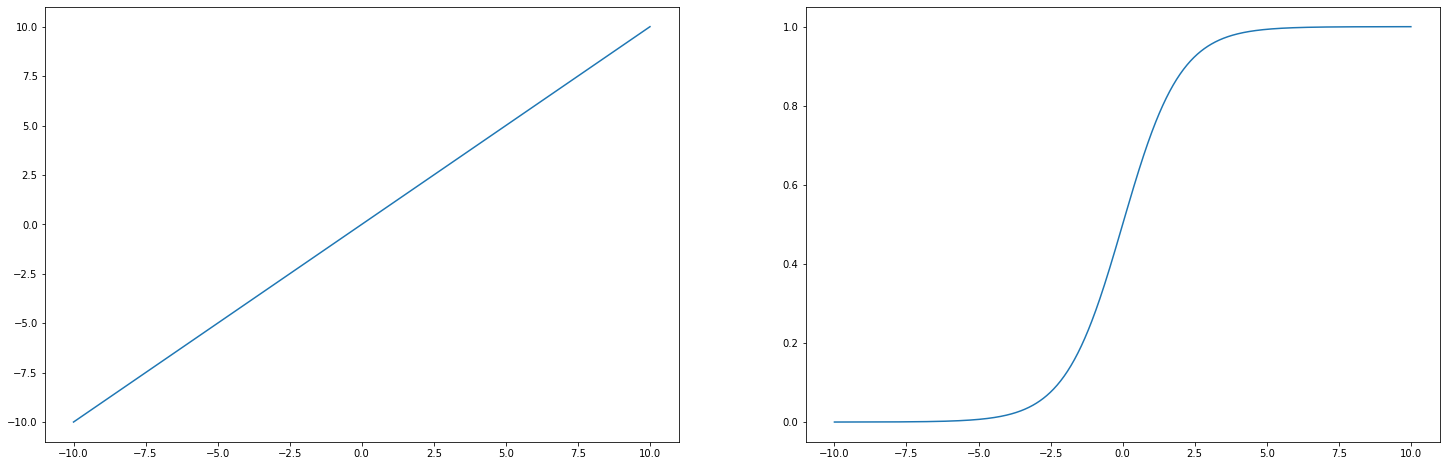

In [217]:
fig, axes = plt.subplots(1,2, figsize=(25,8))
axes[0].plot(x, y)
axes[1].plot(x, transformed_y)

And here's what it looks like in code

## Logistic Regression in PyMC

In [237]:
from scipy import special
with pm.Model() as ab_test:
    
    # This is all the same linear regression as before
    sigma = pm.Normal("p_convert", 1)
    β = pm.Normal("β", 0, 1, size=2)
    
    mu = pm.Deterministic("mu", β[0] + β[1]*df["age"])
    
    # Our is our new sigmoid transoformation
    p = pm.Deterministic("p", pm.math.sigmoid(mu))
    
    # Switch to Bernoulli because we're predicting individual observations
    obs = pm.Bernoulli("obs", p=p, observed=df["converted_bool"].values)
    idata_sigmoid = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_convert, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The acceptance probability does not match the target. It is 0.8823, but should be close to 0.8. Try to increase the number of tuning steps.


In [238]:
az.summary(idata_sigmoid, var_names=["β"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β[0],1.587,0.265,1.074,2.079,0.007,0.005,1518.0,1953.0,1.0
β[1],-0.080,0.008,-0.095,-0.066,0.000,0.000,1491.0,2075.0,1.0


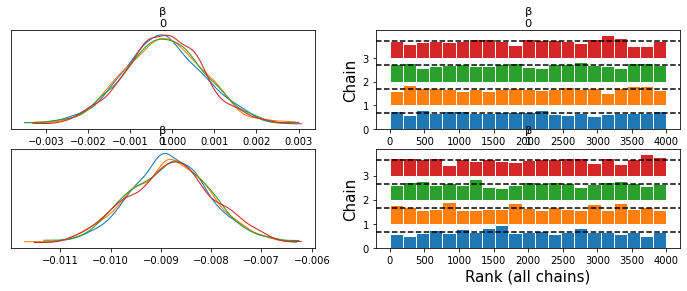

In [235]:
az.plot_trace(idata_sigmoid, var_names=["β"], compact=False, kind="rank_bars");

## This is a generalized linear model
$$
g(\mu_i) = \eta_i = \mathbf{x}_i^T\mathbf{\beta}
$$

We took an ordinary linear regression, and how we've generalized it. Its typically notated as this

G is the the **link function** in this case sigmoid. You're going to see other versions of this in the upcoming lesson

## Link functions in Bambi

In [25]:
model = bmb.Model("converted['Yes'] ~ age", df, family="bernoulli")
idata = model.fit(draws=2000, target_accept=0.85, random_seed=SEED)
az.summary(idata)

Modeling the probability that converted==Yes
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, age]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.706,0.278,1.190,2.233,0.004,0.003,4318.0,5194.0,1.0
age,-0.084,0.008,-0.099,-0.068,0.000,0.000,3679.0,4613.0,1.0


Turns out we can 
Look we get the same answer as the PyMC Model!

## Section Recap
* Transformations are the tool that turns linear regression into generalized linear equations
* Typically these are referred to as link functions 

# End to End Analysis with Bambi and A infinite testing
Lets go through the Bayesian workflow step by step to ensure we have a reliable result for out boss

## Single bool covariate regression

In [26]:
model = bmb.Model("converted['Yes'] ~ likes_videogames+0", df, family="bernoulli")
idata = model.fit(draws=2000, target_accept=0.85, random_seed=SEED)
az.summary(idata)

Modeling the probability that converted==Yes
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likes_videogames]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
likes_videogames[No],-2.219,0.150,-2.495,-1.939,0.002,0.001,7177.0,5798.0,1.0
likes_videogames[Yes],-0.584,0.097,-0.766,-0.402,0.001,0.001,6382.0,4213.0,1.0


In [27]:
special.expit(az.summary(idata)["mean"])

likes_videogames[No]     0.098057
likes_videogames[Yes]    0.358013
Name: mean, dtype: float64

Lets start with the easiest thing. Now check this out. Do these numbers look familiar? that's because its the exact same thing as our first AB Test how cool is that? When we transform the means we end up with our original probabilities

## Lets fit on age and A infinite testing

In [28]:
model = bmb.Model("converted['Yes'] ~ age", df, family="bernoulli")
idata = model.fit(draws=2000, target_accept=0.85, random_seed=SEED)
az.summary(idata)

Modeling the probability that converted==Yes
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, age]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.706,0.278,1.190,2.233,0.004,0.003,4318.0,5194.0,1.0
age,-0.084,0.008,-0.099,-0.068,0.000,0.000,3679.0,4613.0,1.0


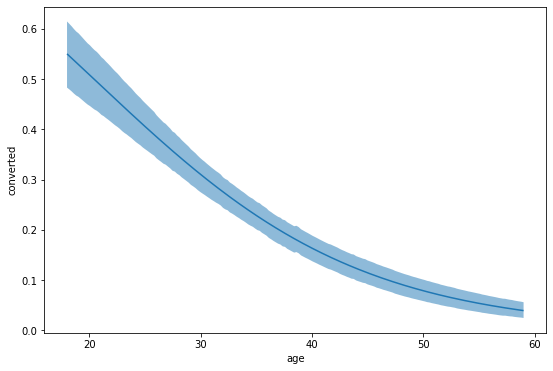

In [29]:
from bambi.plots import plot_cap
fig, ax = plt.subplots(figsize=(9, 6))
plot_cap(model, idata, ["age"], ax=ax);

Check this out! We have the answer for our boss. As age increase prob decrease by this much.

This is basically A infinite testing because we have the p value as an INFINITE amount of ages along the x range. How freaking cool is that?

## Lets fit on age and likes videogames


In [30]:
model = bmb.Model("converted['Yes'] ~ age + likes_videogames", df, family="bernoulli")
idata = model.fit(draws=2000, target_accept=0.85, random_seed=SEED)
az.summary(idata)

Modeling the probability that converted==Yes
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, age, likes_videogames]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.010,0.304,0.443,1.574,0.003,0.002,8509.0,6175.0,1.0
age,-0.097,0.009,-0.113,-0.080,0.000,0.000,4850.0,4939.0,1.0
likes_videogames[Yes],1.978,0.200,1.611,2.354,0.003,0.002,5501.0,5687.0,1.0


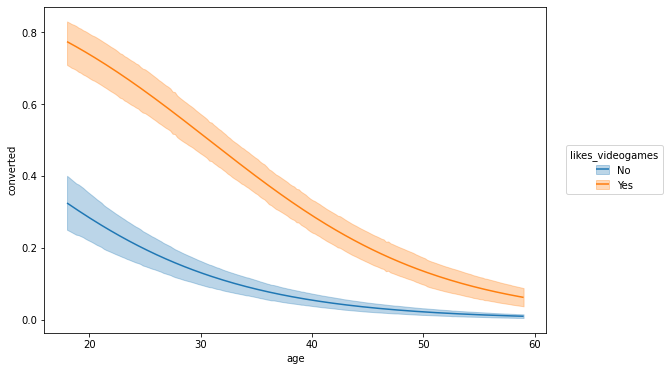

In [31]:
fig, ax = plt.subplots(figsize=(9, 6))
plot_cap(model, idata, ["age", "likes_videogames"], ax=ax);

Holy crap guys this result is truly mindblowing. Not only do we know the prob at every age. When we control for whether people like videogames or not we see a totally different trend.

Now when you go talk to your boss you not only provided the age insight, but you can recommend who to target per age and preference. And with this intuitive plot your boss is sure to give you a rise!

## Making a prediction

In [32]:
df_predict = pd.DataFrame({"age": [20, 30, 40], "likes_videogames":["No","Yes", "Yes"]})
predictions = model.predict(idata, data=df_predict, inplace=False, kind="pps")

In [33]:
predictions.posterior_predictive.mean(["chain", "draw"])["converted"]

<xarray.DataArray 'converted' (converted_dim_0: 3)>
array([0.282875, 0.526625, 0.2875  ])
Coordinates:
  * converted_dim_0  (converted_dim_0) int64 0 1 2

Check this out
Turns out a 20 year old will convert at 20 percent rate, even if they dont like videogames, which is less than 30 year old that does like video games, and about the same as a 40 year old that likes videogames!

Now if any new customer comes in we can predict their prob conversion

## Section Recap
* AB testing is equivalent to categorical regression
* plot_cap helps us easily visualize continuous results
  * Gives us the answer for probability of conversion with age
* Since this is regression we can even control for preference quite easily
  * Can easily discern the differing trend in conversion between the two groups
* Predictions are quite easy as well!

# Logistic Regression in practice
**Insert applied example here**

## Section Recap
* Recap 1
* Recap 2
* Recap 3

# Lesson Recap


# Appendix Section: Binomial Model
If we'd rather prefer binomial heres how todo it.

In [34]:
df

,age,likes_videogames,likes_videogames_bool,p_convert,converted_bool,converted
355,18.0,Yes,1,0.768525,1,Yes
720,18.0,Yes,1,0.768525,1,Yes
678,18.0,No,0,0.310026,0,No
113,18.0,No,0,0.310026,0,No
425,18.0,No,0,0.310026,0,No
...,...,...,...,...,...,...
825,59.0,Yes,1,0.052154,0,No
207,59.0,No,0,0.007392,0,No
170,59.0,Yes,1,0.052154,0,No
436,59.0,Yes,1,0.052154,0,No


In [35]:
binom_df = df[["likes_videogames", "age", "converted_bool"]].groupby(["likes_videogames", "age"]).agg([np.sum, len])
binom_df.columns = ["Converted", "Count"]

binom_df  = binom_df.reset_index()
binom_df

,likes_videogames,age,Converted,Count
0,No,18.0,2,9
1,No,19.0,3,8
2,No,20.0,1,8
3,No,21.0,1,17
4,No,22.0,3,17
...,...,...,...,...
79,Yes,55.0,0,22
80,Yes,56.0,0,13
81,Yes,57.0,1,14
82,Yes,58.0,0,9


In [36]:
conversion_model = bmb.Model("p(Converted, Count) ~ likes_videogames + age", binom_df, family="binomial")
conversion_model_fitted = conversion_model.fit(draws=2000, target_accept=0.85, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, likes_videogames, age]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.


In [37]:
az.summary(conversion_model_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.006,0.306,0.469,1.625,0.003,0.002,8685.0,5865.0,1.0
likes_videogames[Yes],1.978,0.198,1.598,2.334,0.003,0.002,4890.0,5468.0,1.0
age,-0.097,0.009,-0.114,-0.081,0.000,0.000,4790.0,5618.0,1.0


In [38]:
conversion_model = bmb.Model("p(Converted, Count) ~ likes_videogames + age", binom_df, family="binomial")
conversion_model_fitted = conversion_model.fit(draws=2000, target_accept=0.85, random_seed=SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, likes_videogames, age]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.


In [39]:
az.summary(conversion_model_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.006,0.306,0.469,1.625,0.003,0.002,8685.0,5865.0,1.0
likes_videogames[Yes],1.978,0.198,1.598,2.334,0.003,0.002,4890.0,5468.0,1.0
age,-0.097,0.009,-0.114,-0.081,0.000,0.000,4790.0,5618.0,1.0


## Temporary Appendix
Code that doesn't need to be in the script but I don't want to get rid of yet

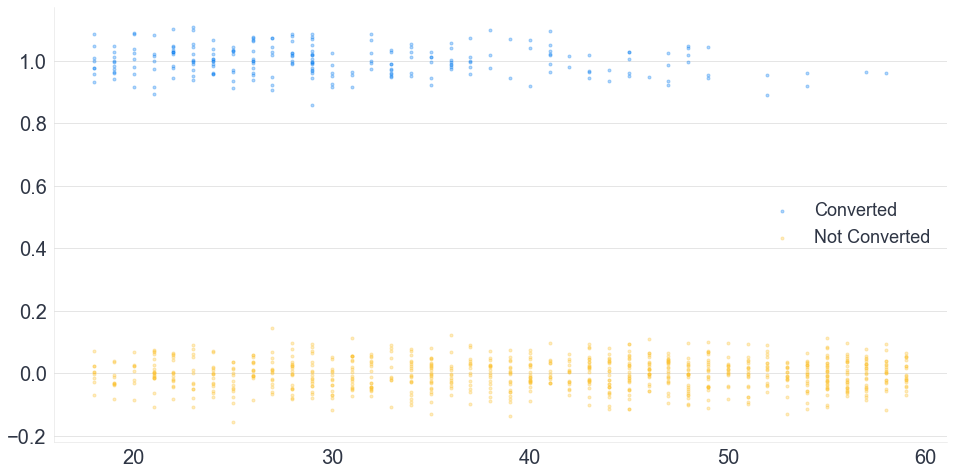

In [106]:
fig, ax = plt.subplots(1)

converted_filter = df["converted_bool"].astype(bool)
# Add some jitter

jittered_y = df["converted_bool"] + stats.norm(scale=.05).rvs(df.shape[0])

alpha = .3
ax.scatter(df.loc[converted_filter, "age"],
          jittered_y[converted_filter],
          label="Converted",
          alpha=alpha)

ax.scatter( df.loc[~converted_filter, "age"],
           jittered_y[~converted_filter],
           label="Not Converted",
           alpha=alpha)

plt.legend();